In [1]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Step 1: 读取数据
file_path = "../data/PSY_HKUST_CAUSAL_USER_DETAIL_202501_NEW.txt"
df = pd.read_csv(file_path, sep="|")
df.columns = df.columns.str.replace(r'^psy_hkust_causal_user_detail_202501_new\.', '', regex=True)
df.columns = df.columns.str.lower()
df.replace('NULL', np.nan, inplace=True)
df['call_cnt'] = df['call_cnt'].fillna(0)
df['call_success_cnt'] = df['call_success_cnt'].fillna(0)
df['call_hold_time'] = df['call_hold_time'].fillna(0)
# df['success_rate'] = df['call_success_cnt'] / df['call_cnt']

# # P(Y=1 | A=0, T=1)
# p_y_given_a0_t1 = df[(df['call_cnt'] > 0) & (df['call_success_cnt'] == 0)]['is_order'].mean()

# # P(Y=1 | A=1, T=1)
# p_y_given_a1_t1 = df[(df['call_cnt'] > 0) & (df['call_success_cnt'] > 0)]['is_order'].mean()

# # 打印两种情况
# print(f"P(Y=1 | A=1, T=1) = {p_y_given_a1_t1:.4f}")
# print(f"P(Y=1 | A=0, T=1) = {p_y_given_a0_t1:.4f}")


# Step 6: 构造分析组
df['treat_cnt'] = (df['call_cnt'] > 0).astype(int)
df['treat_succ_cnt'] = (df['call_success_cnt'] > 0).astype(int)
df['treat_dur'] = (df['call_hold_time'] > 0).astype(int)

# P(Y=1 | A=1, T=1)
p_y_given_a1_t1 = df[(df['treat_cnt'] == 1) & (df['treat_succ_cnt'] == 1)]['is_order'].mean()
# P(Y=1 | A=0, T=1)
p_y_given_a0_t1 = df[(df['treat_cnt'] == 1) & (df['treat_succ_cnt'] == 0)]['is_order'].mean()

# 打印两种情况
print(f"P(Y=1 | A=1, T=1) = {p_y_given_a1_t1:.4f}")
print(f"P(Y=1 | A=0, T=1) = {p_y_given_a0_t1:.4f}")
df['success_rate'] = df['treat_succ_cnt'] / df['treat_cnt']
print(df[['call_cnt', 'call_success_cnt', 'success_rate', 'call_hold_time']].describe(percentiles=[0.5,0.6, 0.7,0.8, 0.9]))

# Step 7: 输出订购率
print("📞 Subscription Rate by Call Frequency Group:")
print(df.groupby('treat_cnt')['is_order'].mean().rename({0: 'control', 1: 'treat_cnt'}))
print("\n🎯 Subscription Rate by Call Success Group:")
print(df.groupby('treat_succ_cnt')['is_order'].mean().rename({0: 'control', 1: 'treat_succ_cnt'}))
print("\n⏱️ Subscription Rate by Call Duration Group:")
print(df.groupby('treat_dur')['is_order'].mean().rename({0: 'control', 1: 'treat_dur'}))

P(Y=1 | A=1, T=1) = 0.1740
P(Y=1 | A=0, T=1) = 0.0264
            call_cnt  call_success_cnt   success_rate  call_hold_time
count  306397.000000     306397.000000  155854.000000   306397.000000
mean        2.838177          0.259014       0.407548        7.732054
std         4.827881          0.581107       0.491380       40.579661
min         0.000000          0.000000       0.000000        0.000000
50%         1.000000          0.000000       0.000000        0.000000
60%         2.000000          0.000000       1.000000        0.000000
70%         4.000000          0.000000       1.000000        0.000000
80%         6.000000          1.000000       1.000000        0.000000
90%         7.000000          1.000000       1.000000        2.000000
max        58.000000         14.000000       1.000000     2317.000000
📞 Subscription Rate by Call Frequency Group:
treat_cnt
control      0.022346
treat_cnt    0.086549
Name: is_order, dtype: float64

🎯 Subscription Rate by Call Success Group:
tr

🔍 Potential Confounders (SHAP Intersection):
['product_rent', 'm_add_duration_01', 'product_id', 'm_cur_income', 'join_month', 'cust_type', 'user_state_codeset', 'm_sw_status_month', 'm_add_gs_234g_net', 'm_num_bill_duration', 'age', 'm_add_call_times']
number of confounders: 12


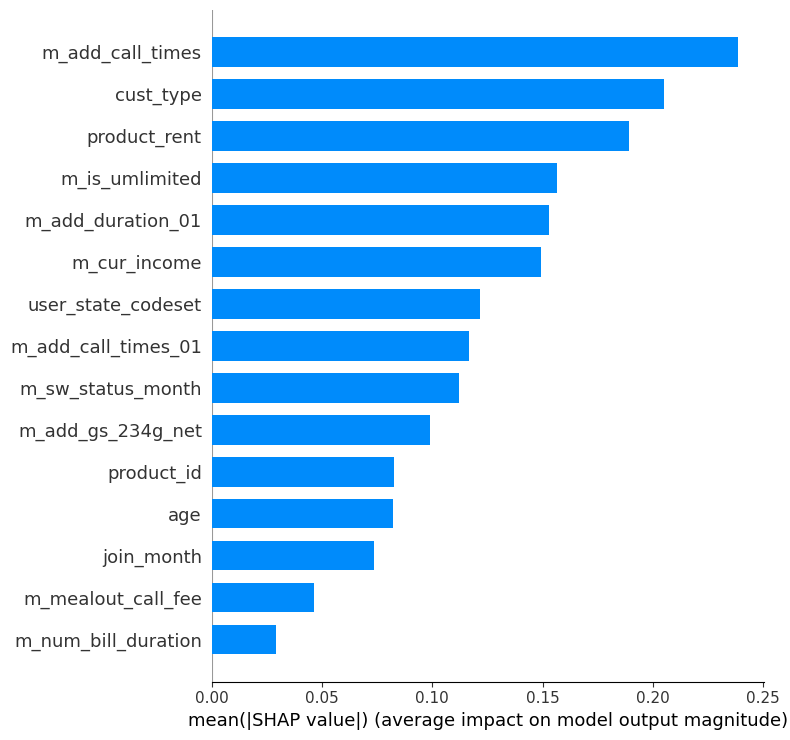

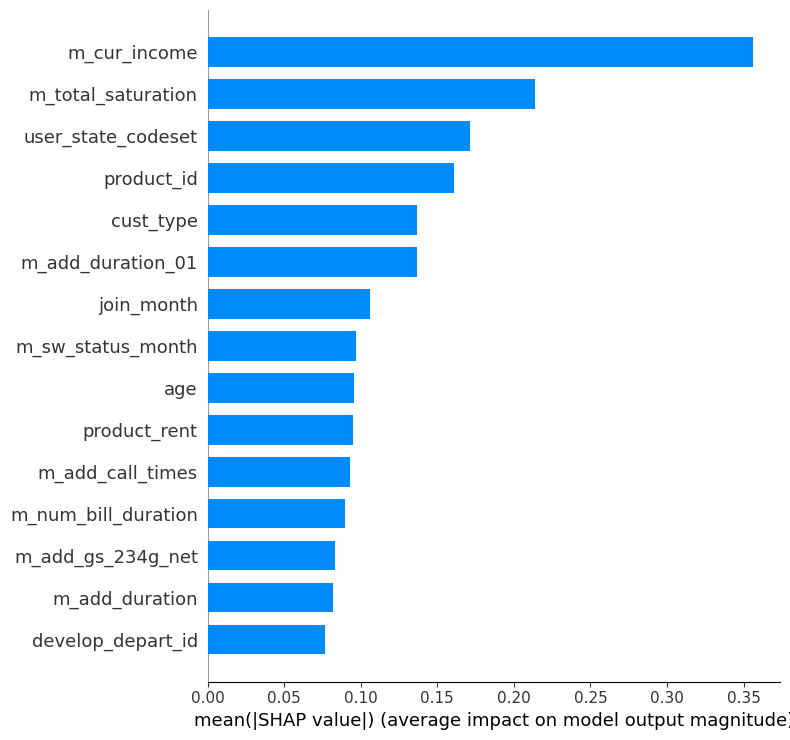

                feature  mean_abs_shap
13     m_add_call_times       0.238584
30            cust_type       0.204805
1          product_rent       0.188942
31       m_is_umlimited       0.156700
16    m_add_duration_01       0.152744
4          m_cur_income       0.149318
29   user_state_codeset       0.121565
14  m_add_call_times_01       0.116664
34    m_sw_status_month       0.112206
33    m_add_gs_234g_net       0.098880
               feature  mean_abs_shap
4         m_cur_income       0.356005
18  m_total_saturation       0.213883
29  user_state_codeset       0.171494
27          product_id       0.160901
30           cust_type       0.136957
16   m_add_duration_01       0.136668
0           join_month       0.106121
34   m_sw_status_month       0.097142
2                  age       0.095867
1         product_rent       0.094915


In [2]:
# Step 2: 分类与数值变量分开
categorical_vars = [
    'sex',                   # 性别
    'user_type_code',        # 用户类型
    'product_id',            # 产品（按员工套餐分类）【高基数，慎用】
    'develop_depart_id',     # 渠道（战略渠道临时）【超高基数，慎用】
    'user_state_codeset',    # 用户状态编码
    'cust_type',             # 客户类型
    'm_is_umlimited',        # 流量饱和度当月不限量流量用户标识
    'm_prom_tag',            # 纯赠款用户标识
    'm_add_gs_234g_net',     # 当月累计用户使用最高网络类型
    'm_sw_status_month',     # 当月累计5G开关状态
    'm_product_type',        # 产品类型
    'm_have_package',        # 是否有流量包（1是，0否）
    'm_is_over'              # 是否超套（1是，0否）
]

numeric_vars = [
    'join_month',            # 入网月数
    'product_rent',          # 套餐固定月租
    'age',                   # 年龄
    'stop_times',            # 当月累计停机次数
    'm_cur_income',          # 当月出账收入
    'm_stream_fee',          # 流量收入
    'm_mealout_qt_fee',      # 套餐外其他费
    'm_mealout_sms_fee',     # 套餐外短信费
    'm_mealout_call_fee',    # 套餐外通话费
    'm_add_stream',          # 当月累计流量
    'm_add_free_stream',     # 当月累计免费流量
    'm_add_stream_bill',     # 当月累计收费流量(M)
    'm_addup_dis_cfee',      # 当月累计流量使用费用(元)
    'm_add_call_times',      # 当月累计通话次数
    'm_add_call_times_01',   # 当月累计主叫通话次数
    'm_add_duration',        # 当月累计通话时长
    'm_add_duration_01',     # 当月累计主叫通话时长
    'm_num_bill_duration',   # 当月累计计费时长
    'm_total_saturation',    # 流量饱和度（当月整体使用）
    'm_cur_cz_fee_add',      # 当月累计充值金额
    'm_cur_cz_cn_add',       # 当月累计充值次数
    'm_mon_complaint_cnt',   # 当月累计客服投诉次数
    'm_add_sms_nums',        # 当月累计短信条数
    'm_add_sms_nums_01',     # 当月累计主叫短信条数
    'm_not_package_use'      # 包外流量（当月）（单位G）
]

treatment_vars = [
    'call_cnt',              # 当月外呼次数
    'call_success_cnt',      # 当月接通次数
    'call_hold_time'         # 当月外呼时长
]

output_vars = [
    'is_order',              # 是否受理成功（1-成功，0-失败）
    'accept_date',           # 受理时间
    'productdiscnt_code',    # 受理资费编码
    'product_lev_1',         # 资费类型一级
    'product_lev_2',         # 资费类型二级
    'product_lev_3'          # 资费类型三级
]

# Step 3: 填补缺失值
df[numeric_vars] = df[numeric_vars].fillna(df[numeric_vars].median())
df[categorical_vars] = df[categorical_vars].fillna('unknown')

# Step 4: Label Encoding 替代 One-hot
for col in categorical_vars:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Step 5: 构建特征集 X（数值 + 分类）
X = df[numeric_vars + categorical_vars].astype(float)

# Step 8: SHAP 分析构造
y_treatment = df['treat_succ_cnt']
y_outcome = df['is_order']

model_treat = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42)
model_treat.fit(X, y_treatment)

model_outcome = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42)
model_outcome.fit(X, y_outcome)

explainer_treat = shap.TreeExplainer(model_treat)
shap_values_treat = explainer_treat.shap_values(X)

explainer_outcome = shap.TreeExplainer(model_outcome)
shap_values_outcome = explainer_outcome.shap_values(X)

# Step 9: 计算特征重要性（平均 SHAP 值）
mean_shap_treat = np.abs(shap_values_treat).mean(axis=0)
mean_shap_outcome = np.abs(shap_values_outcome).mean(axis=0)

importance_treat = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_shap_treat
}).sort_values(by='mean_abs_shap', ascending=False)

importance_outcome = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_shap_outcome
}).sort_values(by='mean_abs_shap', ascending=False)

# Step 10: 找出交集特征（重要混淆变量）
top_treat = set(importance_treat.head(15)['feature'])
top_outcome = set(importance_outcome.head(15)['feature'])
confounder_candidates = list(top_treat & top_outcome)

print("🔍 Potential Confounders (SHAP Intersection):")
print(confounder_candidates)
print("number of confounders:", len(confounder_candidates))

# Step 11: 可视化 SHAP 前5特征
shap.summary_plot(shap_values_treat, X, plot_type="bar", max_display=15, show=False)
plt.savefig("../figures/shap_treat_bar.png", bbox_inches='tight')
plt.show()

shap.summary_plot(shap_values_outcome, X, plot_type="bar", max_display=15, show=False)
plt.savefig("../figures/shap_outcome_bar.png", bbox_inches='tight')
plt.show()

print(importance_treat.head(10))
print(importance_outcome.head(10))


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# ===============================
# Step 1: 设置处理变量（Top 10%）
# ===============================

# 选取 SHAP 分析后确认的协变量
covariates = confounder_candidates
# covariates = ['cust_type', 'm_add_duration_01', 'm_cur_income', 'm_sw_status_month', 'product_rent', 'user_state_codeset']

# 构建子集
df_cov = df[covariates + ['treat_cnt', 'treat_succ_cnt', 'treat_dur', 'is_order']].dropna().copy()

# ===============================
# Step 2: 定义 PSM + 标准化 + 匹配函数
# ===============================
def psm_estimate(df, treatment_col):
    X_raw = df[covariates]
    T = df[treatment_col]

    # 标准化 covariates（很关键）
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)

    # 训练 propensity score 模型
    model = LogisticRegression(max_iter=3000)
    model.fit(X, T)
    df = df.copy()
    df['pscore'] = model.predict_proba(X)[:, 1]

    # 1:1 最近邻匹配
    treated = df[df[treatment_col] == 1].copy()
    control = df[df[treatment_col] == 0].copy()

    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(control[['pscore']])
    distances, indices = nn.kneighbors(treated[['pscore']])

    matched_control = control.iloc[indices.flatten()].copy().reset_index(drop=True)
    matched_treated = treated.reset_index(drop=True)

    # 匹配后订购率差
    matched_diff = matched_treated['is_order'].mean() - matched_control['is_order'].mean()

    # 匹配前订购率差
    unmatched_diff = treated['is_order'].mean() - control['is_order'].mean()

    # 偏差估计
    bias = unmatched_diff - matched_diff

    return unmatched_diff, matched_diff, bias, matched_treated, matched_control

# ===============================
# Step 3: 分别执行 treatment/duration
# ===============================
result_cnt  = psm_estimate(df_cov.copy(), 'treat_cnt')
result_succ = psm_estimate(df_cov.copy(), 'treat_succ_cnt')
result_dur  = psm_estimate(df_cov.copy(), 'treat_dur')
# ===============================
# Step 4: 打印匹配结果
# ===============================
print("📞 Call Frequency (call_cnt)")
print(f"Unmatched Diff: {result_cnt[0]:.4%}, Matched Diff: {result_cnt[1]:.4%}, Bias: {result_cnt[2]:.4%}\n")

print("✅ Call Success Count (call_success_cnt)")
print(f"Unmatched Diff: {result_succ[0]:.4%}, Matched Diff: {result_succ[1]:.4%}, Bias: {result_succ[2]:.4%}\n")

print("⏱️ Call Duration (call_hold_time)")
print(f"Unmatched Diff: {result_dur[0]:.4%}, Matched Diff: {result_dur[1]:.4%}, Bias: {result_dur[2]:.4%}")

📞 Call Frequency (call_cnt)
Unmatched Diff: 6.4203%, Matched Diff: 6.6370%, Bias: -0.2167%

✅ Call Success Count (call_success_cnt)
Unmatched Diff: 15.0114%, Matched Diff: 15.2351%, Bias: -0.2237%

⏱️ Call Duration (call_hold_time)
Unmatched Diff: 7.0883%, Matched Diff: 8.9743%, Bias: -1.8860%


df['treat_cnt'] = (df['call_cnt'] > 0).astype(int)
df['treat_succ_cnt'] = (df['call_success_cnt'] > 0).astype(int)
df['treat_dur'] = (df['call_hold_time'] > 0).astype(int)

📞 Call Frequency (call_cnt)
Unmatched Diff: 6.4203%, Matched Diff: 6.6755%, Bias: -0.2552%

✅ Call Success Count (call_success_cnt)
Unmatched Diff: 15.0114%, Matched Diff: 15.2083%, Bias: -0.1969%

⏱️ Call Duration (call_hold_time)
Unmatched Diff: 7.0883%, Matched Diff: 8.9584%, Bias: -1.8701%
df['treat_cnt'] = (df['call_cnt'] > 5).astype(int)
df['treat_succ_cnt'] = (df['call_success_cnt'] > 3).astype(int)
df['treat_dur'] = (df['call_hold_time'] > 1).astype(int)


📞 Call Frequency (call_cnt)
Unmatched Diff: -1.9222%, Matched Diff: 0.7367%, Bias: -2.6589%

✅ Call Success Count (call_success_cnt)
Unmatched Diff: 2.1427%, Matched Diff: 3.9379%, Bias: -1.7952%

⏱️ Call Duration (call_hold_time)
Unmatched Diff: 7.2904%, Matched Diff: 9.1701%, Bias: -1.8797%
df['treat_cnt'] = (df['call_cnt'] > 3).astype(int)
df['treat_succ_cnt'] = (df['call_success_cnt'] > 1).astype(int)
df['treat_dur'] = (df['call_hold_time'] > 3).astype(int)

📞 Call Frequency (call_cnt)
Unmatched Diff: -0.5943%, Matched Diff: 1.8087%, Bias: -2.4030%

✅ Call Success Count (call_success_cnt)
Unmatched Diff: 8.8357%, Matched Diff: 10.3510%, Bias: -1.5153%

⏱️ Call Duration (call_hold_time)
Unmatched Diff: 7.5597%, Matched Diff: 9.5075%, Bias: -1.9477%
df['treat_cnt'] = (df['call_cnt'] > 1).astype(int)
df['treat_succ_cnt'] = (df['call_success_cnt'] > 5).astype(int)
df['treat_dur'] = (df['call_hold_time'] > 5).astype(int)
📞 Call Frequency (call_cnt)
Unmatched Diff: 3.0380%, Matched Diff: 4.1300%, Bias: -1.0920%

✅ Call Success Count (call_success_cnt)
Unmatched Diff: -2.2755%, Matched Diff: 0.0000%, Bias: -2.2755%

⏱️ Call Duration (call_hold_time)
Unmatched Diff: 8.1023%, Matched Diff: 9.7241%, Bias: -1.6218%

               Variable  SMD_Before  SMD_After
0             cust_type    0.399121   0.000890
1     m_sw_status_month    0.346391   0.052354
2          m_cur_income    0.273576   0.059412
3    user_state_codeset    0.260265   0.009228
4          product_rent    0.215075   0.040617
5            product_id    0.191994   0.008850
6     m_add_gs_234g_net    0.174441   0.027944
7                   age    0.113836   0.009707
8            join_month    0.094728   0.018921
9   m_num_bill_duration    0.077558   0.032604
10     m_add_call_times    0.057281   0.029477
11    m_add_duration_01    0.052121   0.018310


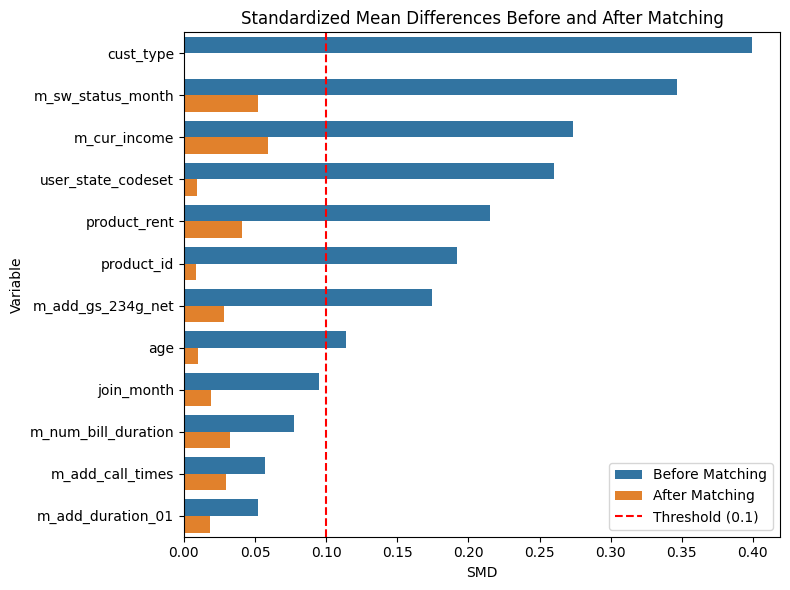

In [4]:
def compute_smd(treated_df, control_df, vars):
    """
    计算每个协变量的标准化差异（SMD）
    """
    smd_results = []

    for var in vars:
        treat_mean = treated_df[var].mean()
        control_mean = control_df[var].mean()
        treat_std = treated_df[var].std()
        control_std = control_df[var].std()
        pooled_std = np.sqrt((treat_std**2 + control_std**2) / 2)

        smd = np.abs(treat_mean - control_mean) / pooled_std if pooled_std != 0 else 0
        smd_results.append({'Variable': var, 'SMD': smd})

    return pd.DataFrame(smd_results).sort_values(by='SMD', ascending=False)

# 使用 treatment 变量为例
unmatched_treated = df_cov[df_cov['treat_succ_cnt'] == 1]
unmatched_control = df_cov[df_cov['treat_succ_cnt'] == 0]
matched_treated = result_succ[3]
matched_control = result_succ[4]

# 匹配前
smd_before = compute_smd(unmatched_treated, unmatched_control, covariates)
smd_before['Stage'] = 'Before Matching'

# 匹配后
smd_after = compute_smd(matched_treated, matched_control, covariates)
smd_after['Stage'] = 'After Matching'

# 合并对比
smd_before_renamed = smd_before.rename(columns={'SMD': 'SMD_Before'}).drop(columns='Stage')
smd_after_renamed = smd_after.rename(columns={'SMD': 'SMD_After'}).drop(columns='Stage')
smd_compare_merge = pd.merge(smd_before_renamed, smd_after_renamed, on='Variable')
# 显示前几行（可选）
print(smd_compare_merge)

smd_compare = pd.concat([smd_before, smd_after])

# 可视化（可选）
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(data=smd_compare, x='SMD', y='Variable', hue='Stage')
plt.axvline(0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.title("Standardized Mean Differences Before and After Matching")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/smd_plot.png")
plt.show()

In [5]:
def psm_estimate_bootstrap(df, treatment_col, B=1000, seed=42):
    np.random.seed(seed)
    X_raw = df[covariates]
    T = df[treatment_col]

    # 标准化
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)

    # 拟合 PS 模型
    model = LogisticRegression(max_iter=3000)
    model.fit(X, T)
    df = df.copy()
    df['pscore'] = model.predict_proba(X)[:, 1]

    # 拆分组
    treated = df[df[treatment_col] == 1].copy().reset_index(drop=True)
    control = df[df[treatment_col] == 0].copy().reset_index(drop=True)

    # 匹配器
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[['pscore']])
    distances, indices = nn.kneighbors(treated[['pscore']])
    matched_control = control.iloc[indices.flatten()].copy()
    matched_treated = treated.copy()

    # 静态 ATT 估计（一次匹配）
    att_point = matched_treated['is_order'].mean() - matched_control['is_order'].mean()
    unmatched_diff = treated['is_order'].mean() - control['is_order'].mean()
    bias = unmatched_diff - att_point

    # === Bootstrap 重采样 ===
    att_bootstrap = []
    n = len(matched_treated)
    for _ in range(B):
        idx = np.random.choice(n, size=n, replace=True)
        y_treat = matched_treated.iloc[idx]['is_order'].values
        y_ctrl = matched_control.iloc[idx]['is_order'].values
        att_b = y_treat.mean() - y_ctrl.mean()
        att_bootstrap.append(att_b)

    # 置信区间
    lower = np.percentile(att_bootstrap, 2.5)
    upper = np.percentile(att_bootstrap, 97.5)

    return {
        'unmatched_diff': unmatched_diff,
        'att': att_point,
        'bias': bias,
        'ci_lower': lower,
        'ci_upper': upper,
        'att_dist': att_bootstrap
    }

result_cnt  = psm_estimate_bootstrap(df_cov.copy(), 'treat_cnt')
result_succ = psm_estimate_bootstrap(df_cov.copy(), 'treat_succ_cnt')
result_dur  = psm_estimate_bootstrap(df_cov.copy(), 'treat_dur')

print("📞 Call Frequency")
print(f"ATT = {result_cnt['att']:.4%}, 95% CI = ({result_cnt['ci_lower']:.4%}, {result_cnt['ci_upper']:.4%})")

print("✅ Call Success")
print(f"ATT = {result_succ['att']:.4%}, 95% CI = ({result_succ['ci_lower']:.4%}, {result_succ['ci_upper']:.4%})")

print("⏱️ Call Duration")
print(f"ATT = {result_dur['att']:.4%}, 95% CI = ({result_dur['ci_lower']:.4%}, {result_dur['ci_upper']:.4%})")

📞 Call Frequency
ATT = 6.6370%, 95% CI = (6.4907%, 6.7916%)
✅ Call Success
ATT = 15.2351%, 95% CI = (14.9107%, 15.5563%)
⏱️ Call Duration
ATT = 8.9743%, 95% CI = (8.5806%, 9.3840%)


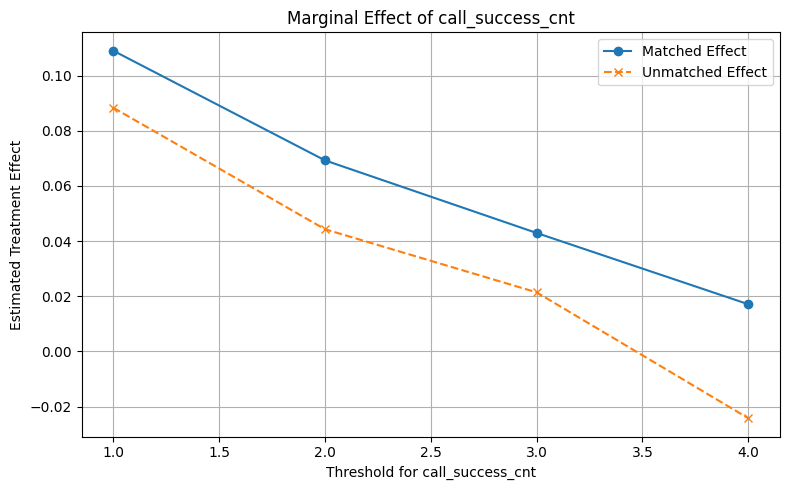

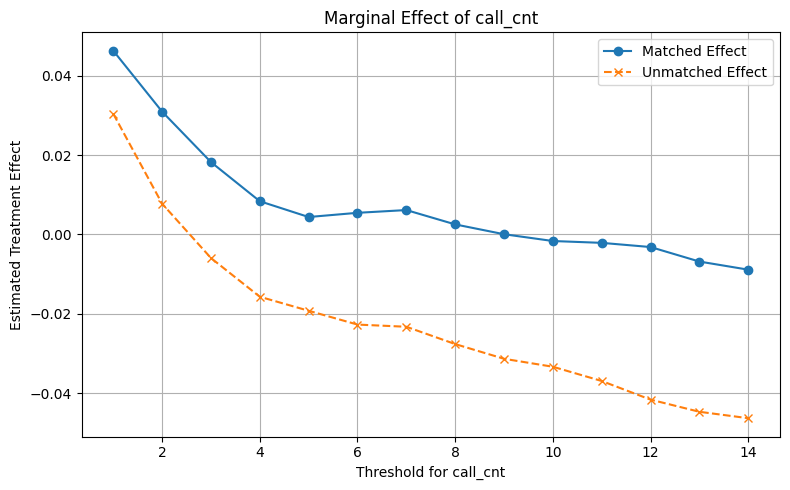

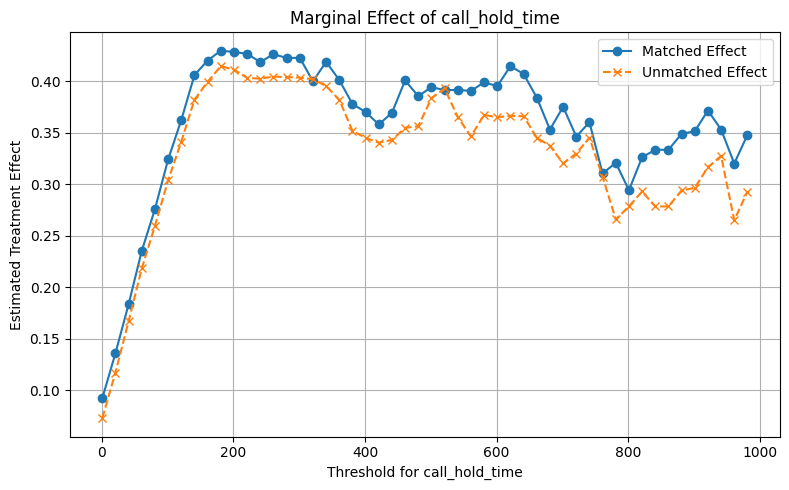

,threshold,n_treated,unmatched_diff,matched_diff,bias
0,1,30872,0.072904,0.092219,-0.019315
1,21,20122,0.117189,0.135971,-0.018782
2,41,14379,0.167036,0.183532,-0.016495
3,61,10994,0.218245,0.235310,-0.017066
4,81,8916,0.259524,0.275796,-0.016272
5,101,7548,0.303697,0.323927,-0.020230
6,121,6430,0.341272,0.362208,-0.020937
7,141,5259,0.381860,0.405781,-0.023920
8,161,4353,0.399326,0.419940,-0.020615
9,181,3721,0.414420,0.429454,-0.015034


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

def run_multiple_psm(df, base_var, thresholds, outcome_col='is_order', save_path=None):
    results = []
    for threshold in thresholds:
        treat_col = f'treat_{base_var}_{threshold}'
        df[treat_col] = (df[base_var] > threshold).astype(int)

        df_cov = df[covariates + [treat_col, outcome_col]].dropna().copy()
        X_raw = df_cov[covariates]
        T = df_cov[treat_col]

        # Propensity score
        scaler = StandardScaler()
        X = scaler.fit_transform(X_raw)
        model = LogisticRegression(max_iter=3000)
        model.fit(X, T)
        df_cov['pscore'] = model.predict_proba(X)[:, 1]

        # Matching
        treated = df_cov[df_cov[treat_col] == 1]
        control = df_cov[df_cov[treat_col] == 0]
        if len(treated) == 0 or len(control) == 0:
            continue

        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(control[['pscore']])
        distances, indices = nn.kneighbors(treated[['pscore']])
        matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
        matched_treated = treated.reset_index(drop=True)

        matched_diff = matched_treated[outcome_col].mean() - matched_control[outcome_col].mean()
        unmatched_diff = treated[outcome_col].mean() - control[outcome_col].mean()
        bias = unmatched_diff - matched_diff

        results.append({
            'threshold': threshold,
            'n_treated': len(treated),
            'unmatched_diff': unmatched_diff,
            'matched_diff': matched_diff,
            'bias': bias
        })

    result_df = pd.DataFrame(results)

    # 绘图 + 导出
    if save_path:
        plt.figure(figsize=(8, 5))
        plt.plot(result_df['threshold'], result_df['matched_diff'], marker='o', label='Matched Effect')
        plt.plot(result_df['threshold'], result_df['unmatched_diff'], marker='x', linestyle='--', label='Unmatched Effect')
        plt.xlabel(f"Threshold for {base_var}")
        plt.ylabel("Estimated Treatment Effect")
        plt.title(f"Marginal Effect of {base_var}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    return result_df

# 保存为 figures 目录下的图片（确保该目录存在）
run_multiple_psm(df.copy(), base_var='call_success_cnt', thresholds=range(1, 5), save_path='../figures/marginal_effect_success_cnt.png')
run_multiple_psm(df.copy(), base_var='call_cnt', thresholds=range(1, 15), save_path='../figures/marginal_effect_call_cnt.png')
run_multiple_psm(df.copy(), base_var='call_hold_time', thresholds=range(1, 1000, 20), save_path='../figures/marginal_effect_hold_time.png')

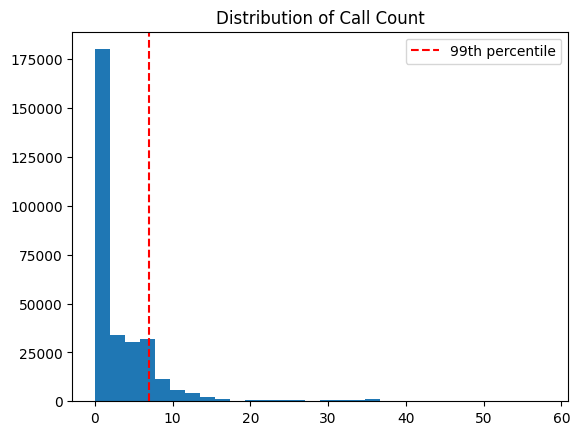

In [7]:

cnt_upper = df['call_cnt'].quantile(0.9)
plt.hist(df['call_cnt'], bins=30)
plt.axvline(cnt_upper, color='red', linestyle='--', label='99th percentile')
plt.title("Distribution of Call Count")
plt.legend()
plt.show()